In [549]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

In [550]:
train_df = pd.read_csv('train.csv', usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'], parse_dates=True)
train_df.head()

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


In [551]:
train_df['date'] = pd.to_datetime(train_df['date'])

In [552]:
train_df = train_df.set_index(['store_nbr', 'family', 'date']).sort_index()

In [553]:
train_df.head()

sales  onpromotion
store_nbr family     date                          
1         AUTOMOTIVE 2013-01-01    0.0            0
                     2013-01-02    2.0            0
                     2013-01-03    3.0            0
                     2013-01-04    3.0            0
                     2013-01-05    5.0            0

In [554]:
sample_submission = pd.read_csv('sample_submission.csv')

In [555]:
sample_submission.columns

Index(['id', 'sales'], dtype='object')

In [952]:
sample_submission.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


In [556]:
oil_df = pd.read_csv('oil.csv', index_col='date', parse_dates=True)

In [557]:
oil_df.head()

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20


In [558]:
hol_df = pd.read_csv('holidays_events.csv', index_col='date', parse_dates=True)

In [559]:
hol_df.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [560]:
store_df = pd.read_csv('stores.csv')

In [561]:
store_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


# EDA

In [562]:
train_df.shape

(3000888, 2)

In [563]:
train_df.head()

sales  onpromotion
store_nbr family     date                          
1         AUTOMOTIVE 2013-01-01    0.0            0
                     2013-01-02    2.0            0
                     2013-01-03    3.0            0
                     2013-01-04    3.0            0
                     2013-01-05    5.0            0

In [564]:
train_avg = pd.DataFrame(train_df.groupby('date').mean())
train_avg.dtypes

sales          float64
onpromotion    float64
dtype: object

In [565]:
train_avg.isna().sum()

sales          0
onpromotion    0
dtype: int64

In [566]:
train_avg.head()

,sales,onpromotion
date,,
2013-01-01,1.409438,0.0
2013-01-02,278.390807,0.0
2013-01-03,202.840197,0.0
2013-01-04,198.911154,0.0
2013-01-05,267.873244,0.0


In [567]:
train_avg.index.dtype

dtype('<M8[ns]')

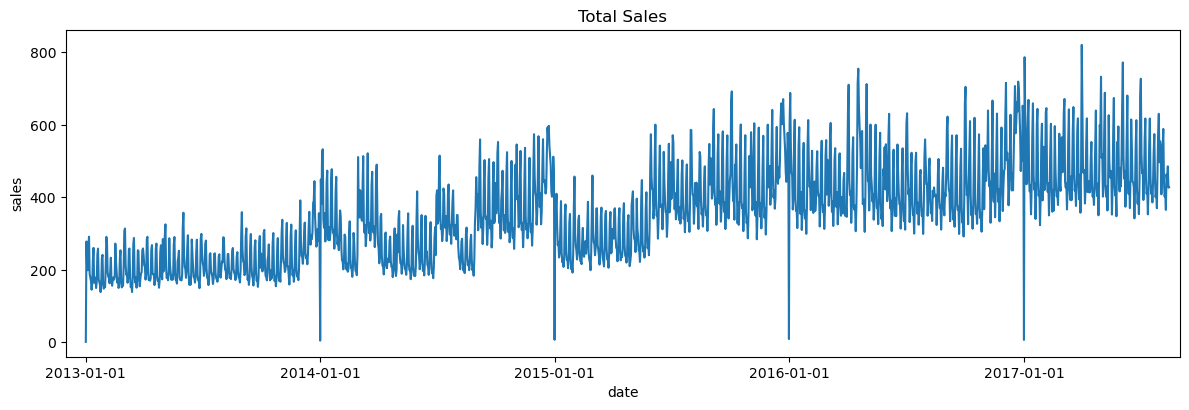

In [568]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.lineplot(data=train_avg, x=train_avg.index, y='sales')
ax.xaxis.set_major_locator(mdates.YearLocator(month=1, day=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1, 5, 9]))
# ax.xaxis.set_minor_formatter(mdates.DateFormatter('%m'))
ax.set_xlim(pd.to_datetime('2012-12-01'), pd.to_datetime('2017-09-01'))
plt.tight_layout()
plt.title('Total Sales')
plt.show()

In [569]:
dates_first_of_year = pd.date_range(start=train_avg.index.min(),
                              end=train_avg.index.max(),
                              freq='YS-JAN')
dates_second_of_year = pd.date_range(start=train_avg.index.min(), 
                                     end=train_avg.index.max(), 
                                     freq='YS-JAN') + pd.DateOffset(days=1)
first_of_year = train_avg[train_avg.index.isin(dates_first_of_year.union(dates_second_of_year))].copy()
first_of_year['sales'] = first_of_year.sales.apply(lambda x: round(x, 3))
first_of_year

,sales,onpromotion
date,,
2013-01-01,1.409,0.000000
2013-01-02,278.391,0.000000
2014-01-01,4.827,0.000000
2014-01-02,449.501,0.000000
2015-01-01,7.168,0.006734
2015-01-02,369.115,2.777217
2016-01-01,9.222,0.089226
2016-01-02,598.584,1.028058
2017-01-01,6.780,0.095398


There seems to be an abrupt drop at the beginning of every year. This can be a seasonality feature.

# Outlining Trend

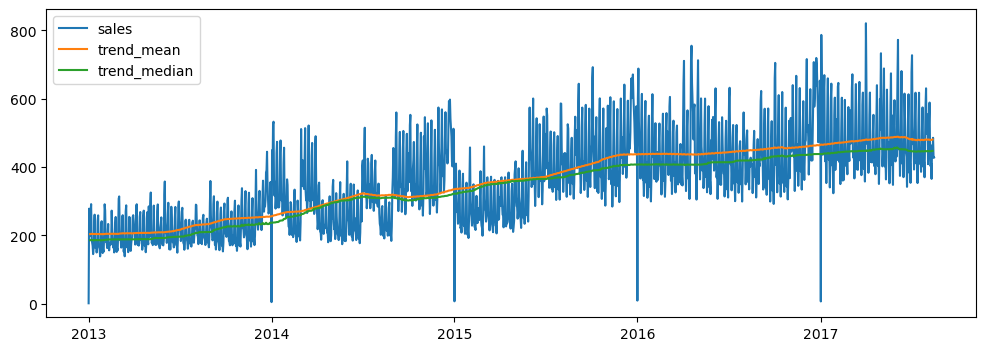

In [570]:
trend_mean = train_avg.sales.rolling(
    window=365,
    center=True,
    min_periods=186,
    
).mean()
trend_median = train_avg.sales.rolling(
    window=365,
    center=True,
    min_periods=186,
    
).median()
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(train_avg.sales, label='sales')
ax.plot(trend_mean, label='trend_mean')
ax.plot(trend_median, label='trend_median')
plt.legend()
plt.show()

# Seasonality

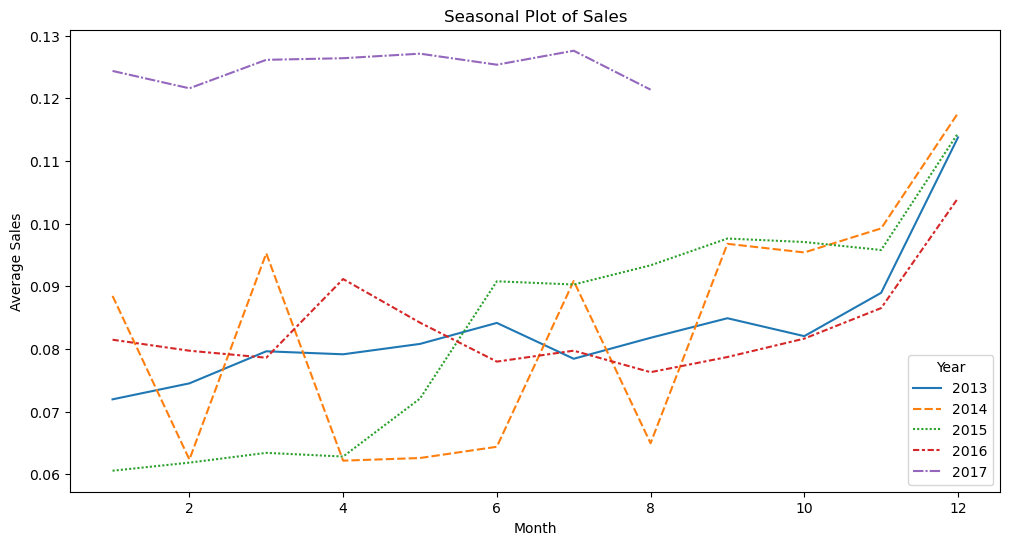

In [571]:
train_avg['year'] = train_avg.index.year
train_avg['month'] = train_avg.index.month
train_avg['week'] = train_avg.index.isocalendar().week
train_avg['day'] = train_avg.index.dayofweek

# Pivot table to rearrange data for seasonal plot (months as columns, years as rows)
seasonal_data_year = train_avg.pivot_table(values='sales', index='month', columns='year', aggfunc='mean')
normalized_seasonal_data_year = seasonal_data_year / seasonal_data_year.sum(axis=0)

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=normalized_seasonal_data_year)
plt.title('Seasonal Plot of Sales')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.legend(title='Year')
plt.show()

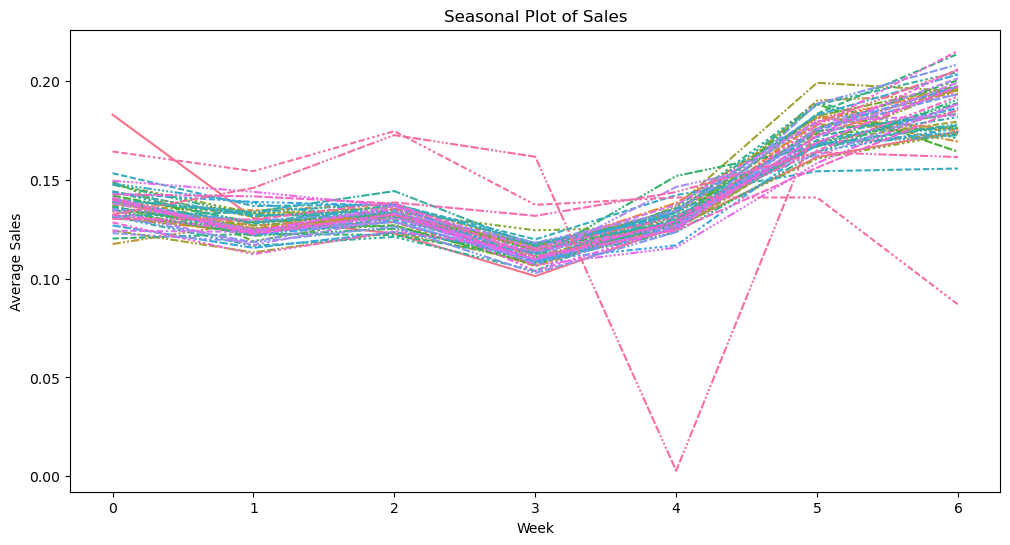

In [572]:
seasonal_data_week = train_avg.pivot_table(values='sales', index='day', columns='week', aggfunc='mean')
normalized_seasonal_data_week = seasonal_data_week / seasonal_data_week.sum(axis=0)

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=normalized_seasonal_data_week, legend=False)
plt.title('Seasonal Plot of Sales')
plt.xlabel('Week')
plt.ylabel('Average Sales')
plt.show()

Above plots affirm that there are strong weekly seasonality. Meanwhile, there could be annual seasonality with increased sales in Month 10, 11, and 12.

In [573]:
# Plotting periodogram

In [574]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    frequencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots(figsize=(12, 6))
    ax.step(frequencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

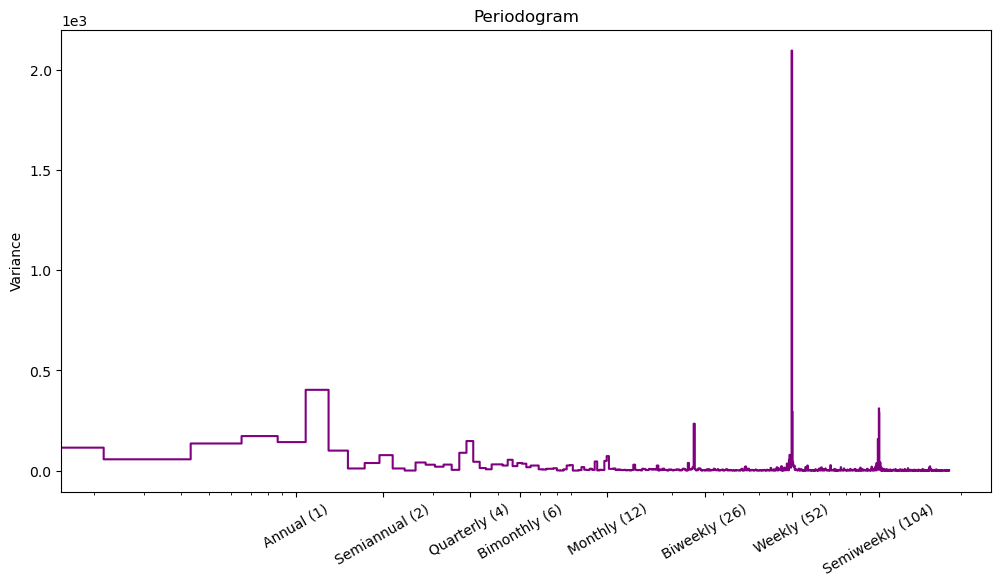

In [575]:
plot_periodogram(train_avg['sales'])
plt.show()

In [576]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [643]:
fourier = CalendarFourier(freq="BME", order=4)

In [644]:
train_avg = train_avg.asfreq('D')
train_avg.ffill(inplace=True)

In [658]:
dp = DeterministicProcess(
    index=train_avg.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample() 

In [659]:
X.columns

Index(['const', 'trend', 's(2,7)', 's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)',
       's(7,7)', 'sin(1,freq=BME)', 'cos(1,freq=BME)', 'sin(2,freq=BME)',
       'cos(2,freq=BME)', 'sin(3,freq=BME)', 'cos(3,freq=BME)',
       'sin(4,freq=BME)', 'cos(4,freq=BME)'],
      dtype='object')

In [660]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error, root_mean_squared_error

In [661]:
y = train_avg['sales']

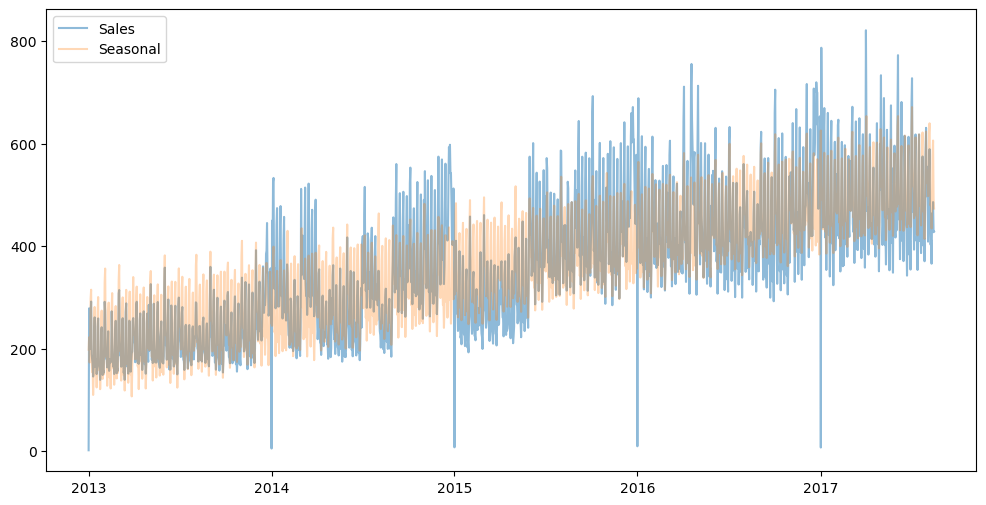

In [662]:
model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)

fig, ax = plt.subplots(figsize=(12, 6))
y_pred = pd.Series(model.predict(X), index=X.index)
ax.plot(y, alpha=0.5, label='Sales')
ax.plot(y_pred, alpha=0.3, label="Seasonal")
ax.legend()
plt.show()

In [663]:
mean_squared_log_error(y_true=y, y_pred=y_pred) ** 0.5

0.27602960735005994

In [664]:
rmse(y, y_pred)

65.66253363700055

# Adding New Year and National Day as Features

In [665]:
X['new_year'] = (X.index.dayofyear == 1)

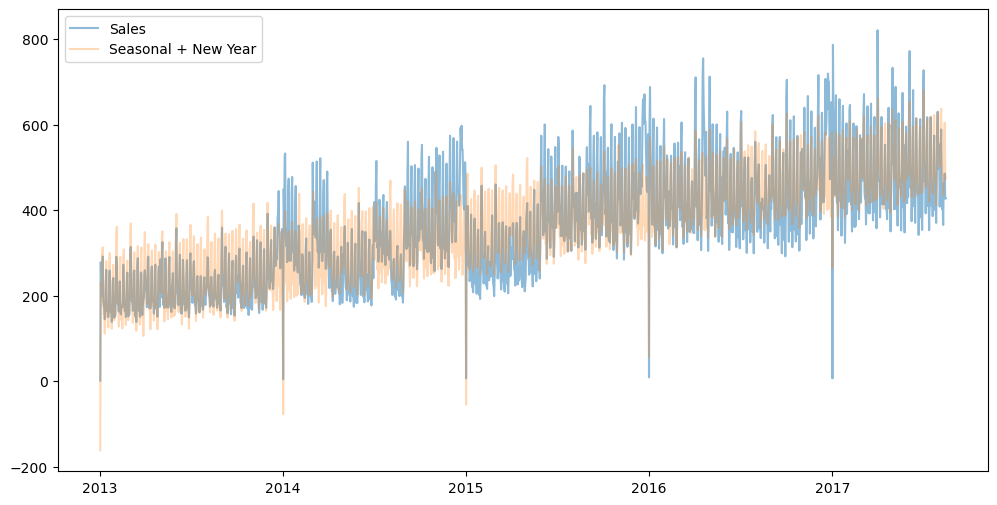

In [666]:
model = LinearRegression(fit_intercept=False).fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)

fig, ax = plt.subplots(figsize=(12, 6))
y_pred = pd.Series(model.predict(X), index=X.index)
ax.plot(y, alpha=0.5, label='Sales')
ax.plot(y_pred, alpha=0.3, label="Seasonal + New Year")
ax.legend()
plt.show()

In [667]:
rmse(y_true=y, y_pred=y_pred)

62.59074386677438

In [668]:
y_pred = y_pred.clip(0.0)

In [669]:
mean_squared_log_error(y_true=y, y_pred=y_pred) ** 0.5

0.20623615798616673

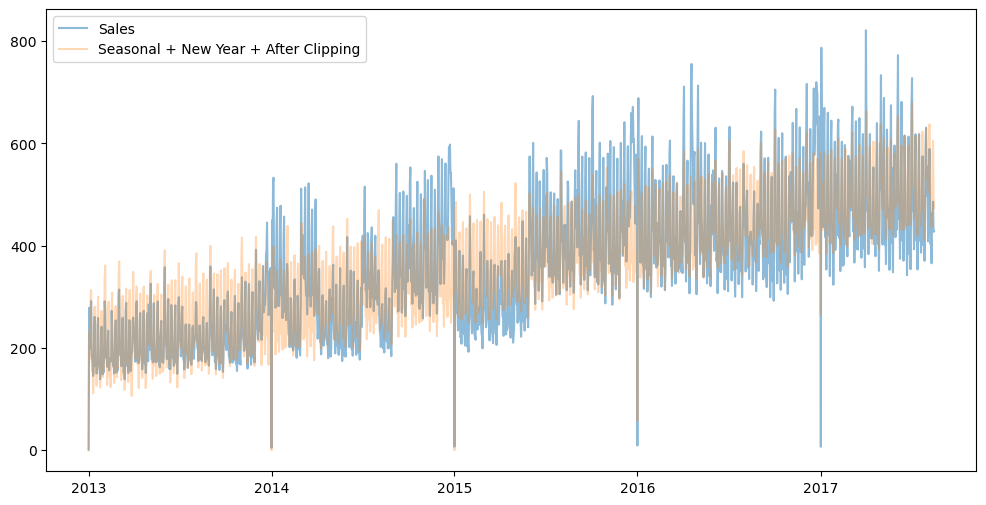

In [670]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(y, alpha=0.5, label='Sales')
ax.plot(y_pred, alpha=0.3, label="Seasonal + New Year + After Clipping")
ax.legend()
plt.show()

In [700]:
hol_df

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...
2017-12-22,Additional,National,Ecuador,Navidad-3,False
2017-12-23,Additional,National,Ecuador,Navidad-2,False
2017-12-24,Additional,National,Ecuador,Navidad-1,False


In [788]:
holiday_events = hol_df.query("locale in ['National', 'Regional'] and date.dt.year != 2012 and date <= '2017-08-15'")['description']

In [789]:
holiday_events = holiday_events.drop_duplicates()

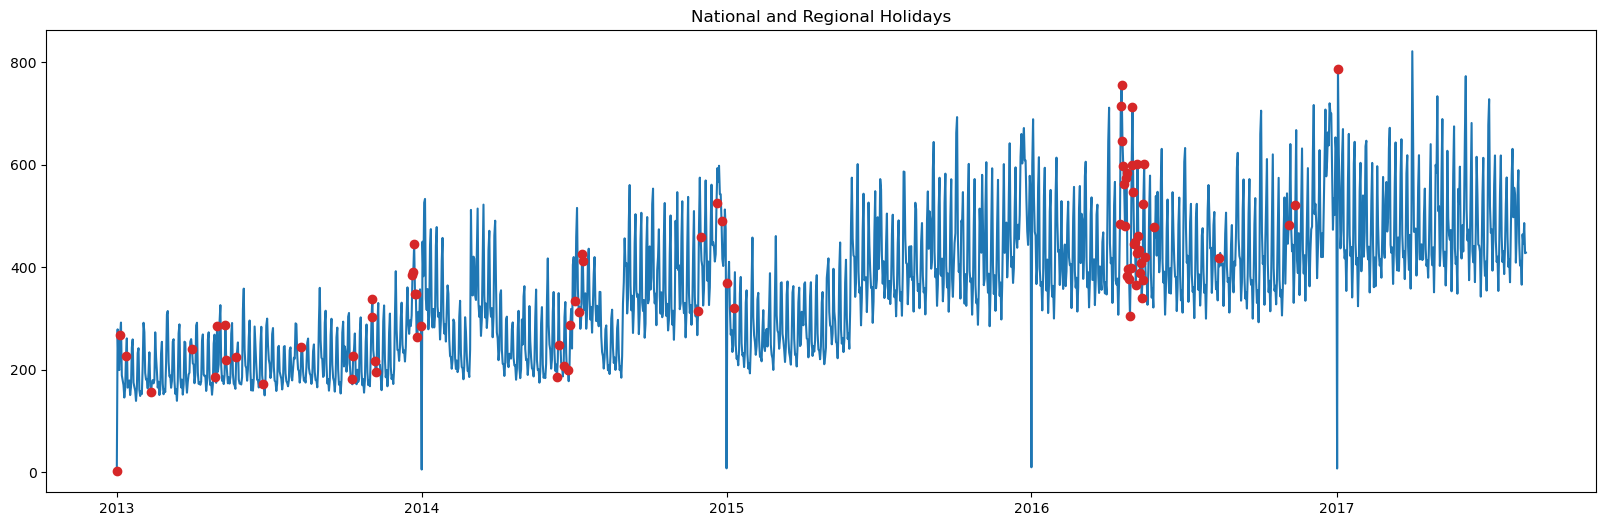

In [790]:
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(y)
plt.plot_date(holiday_events.index, y[holiday_events.index], color='C3')
ax.set_title('National and Regional Holidays')
plt.show()

In [791]:
X_holidays = pd.get_dummies(holiday_events)

X2 = X.merge(X_holidays, on='date', how='left').fillna(0.0)

In [792]:
X.shape

(1688, 17)

In [793]:
X2.shape

(1688, 93)

In [794]:
model = LinearRegression(fit_intercept=False)
model.fit(X2, y)
y_pred_X2 = pd.DataFrame(model.predict(X2), index=X2.index).clip(0.0)

In [795]:
mean_squared_log_error(y_true=y, y_pred=y_pred_X2) ** 0.5

0.19293842338464112

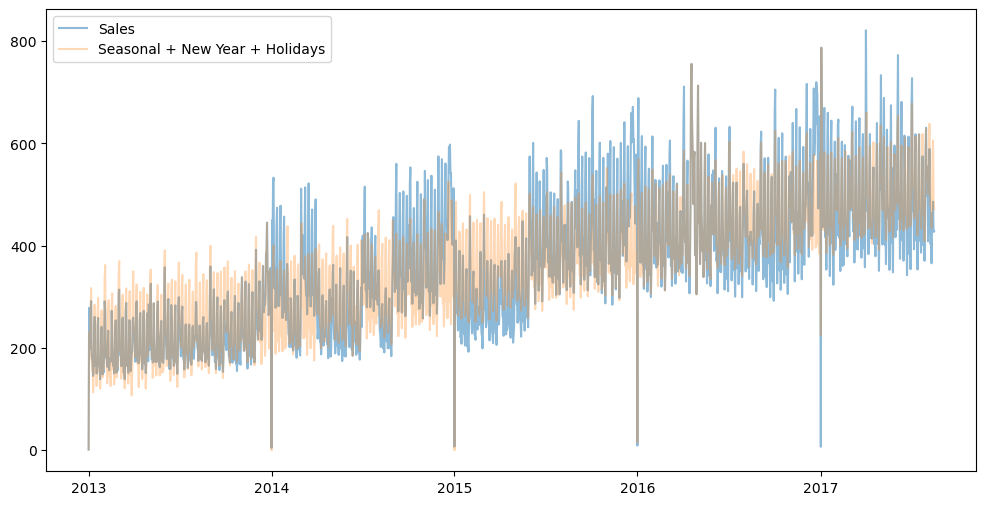

In [796]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(y, alpha=0.5, label='Sales')
ax.plot(y_pred_X2, alpha=0.3, label="Seasonal + New Year + Holidays")
ax.legend()
plt.show()

# Creating Lag Features

Since ts = trend + seasonality + cylic + errors, we want to detrend before applying lags.

In [886]:
from statsmodels.graphics.tsaplots import plot_pacf
import xgboost as xgb

In [906]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)

In [907]:
y_deseasoned = y.squeeze() - y_pred_X2.squeeze()

In [908]:
y_deseasoned.name = 'sales_deaseasoned'

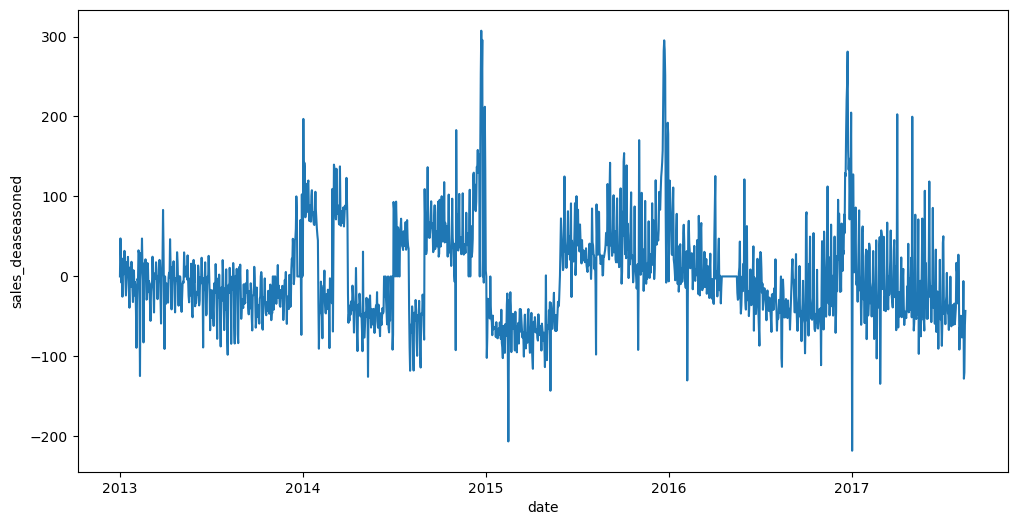

In [909]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=y_deseasoned)
plt.show()

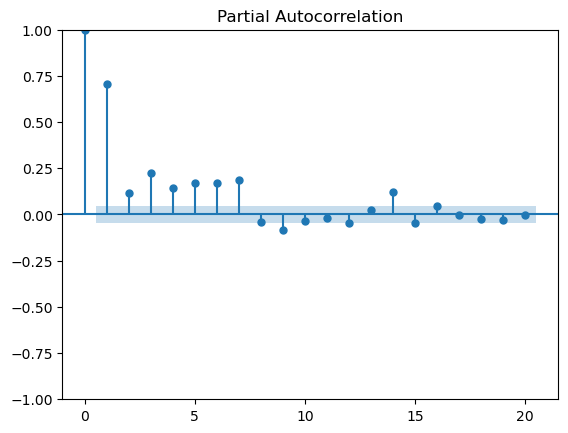

In [910]:
plot_pacf(y_deseasoned, lags=20)
plt.show()

In [911]:
X_lags = make_lags(y_deseasoned, lags=7).fillna(0.0)

In [912]:
y_deseasoned, X_lags = y_deseasoned.align(X_lags, join='inner')

In [913]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_lags, y_deseasoned)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [914]:
xgb_pred = xgb_model.predict(X_lags)

In [915]:
rmse(y_deseasoned, xgb_pred)

4.875298246197162

In [916]:
xgb_pred

array([   4.0743637,   13.656359 ,   23.607237 , ..., -118.63736  ,
        -61.25248  ,  -43.523228 ], dtype=float32)

In [917]:
y_pred_hybrid = xgb_pred.reshape(-1, 1) + y_pred_X2

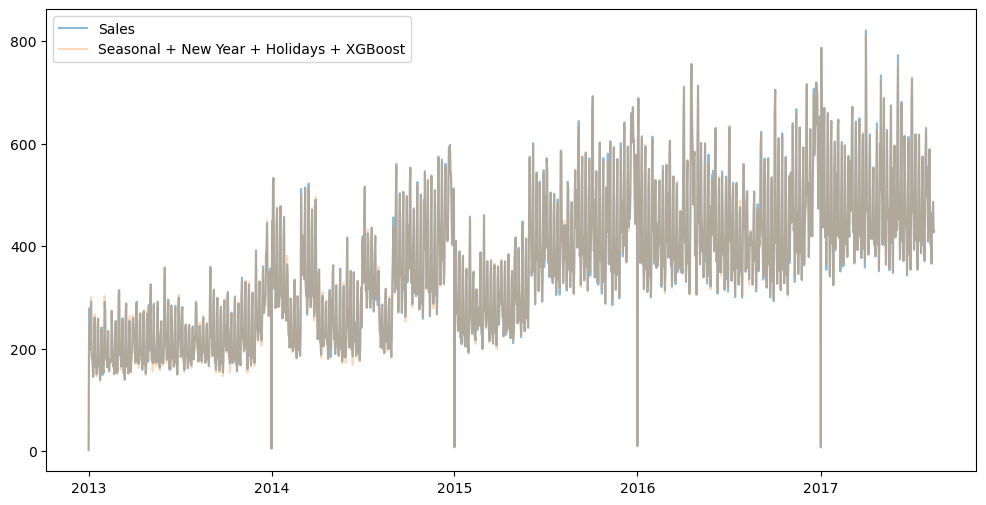

In [924]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(y, alpha=0.5, label='Sales')
ax.plot(y_pred_hybrid, alpha=0.3, label="Seasonal + New Year + Holidays + XGBoost")
ax.legend()
plt.show()

In [921]:
mean_squared_log_error(y_true=y, y_pred=y_pred_hybrid) ** 0.5

0.03174081377313194

In [938]:
test_df = pd.read_csv('test.csv')

In [939]:
test_df = test_df.set_index(['store_nbr', 'family', 'date']).sort_index()

In [948]:
test_data = test_df['onpromotion'].groupby(['family', 'date']).mean().unstack('family')

In [951]:
test_data.shape

(16, 33)